# Evaluation - sDCG, Effort vs Effect, sRBP #

### Wichtige Hinweise ###

- Pfade müssen gegenenfalls angepasst werden (Suche nach Pfad)
- Für sDCG sind b = 2 und bq = 4 gesetzt (wie in der ursprünglichen Evaluation). Falls die Werte geändert werden sollen: sie befinden sich im Abschnitt 'sDCG' (b_sdcg und bq_sdcg)
- Für die Parameter von sRBP (b und p) werden aktuell mit der Methode von Lipani die besten Werte (basierend auf allen verfügbaren Logdaten) bestimmt und verwendet. Sie können im Abschnitt 'sRBP' aber natürlich auch anders gesetzt werden (b_srbp und p_srbp) (ACHTUNG: Habe sie jetzt doch erstmal festgesetzt, weil mit der Methode p=1 bestimmt wurde, wegen (1-p)*res ist 1 für p aber ein ganz schlechter Wert)
- Aktuell werden die Abbildungen nicht gespeichert. Falls das geändert werden soll, müssen nur überall die Zeilen mit "savefig" einkommentiert werden
- Um zu entscheiden, wie viele Querys in der Evaluation betrachtet werden sollen, gibt die Funktion "querynumber_min_max_avg" die minimale, maximale und durchschnittliche Anzahl der Queries in allen log_files aus
- da es lange dauert, sind plot2 und plot3 bei effeff_all auskommentiert. Wenn man sie doch haben möchte, kann man die Zeilen einfach wieder einkommentieren
- wenn es neue Dateien o.ä. gibt, reicht es jetzt, eine Zelle (die, die mit "log_root_path" startet) auszuführen
- einige Dinge sind sehr umständlich gelöst, weil sie mit der Zeit verändert wurden und die Anpassungen so schneller gingen als es neu (und dafür ordentlicher) zu machen
- UPDATE: Fehler bei sDCG behoben; alle angezeigten Dokumente kommen ins Ergebnis (bzw. Platzhalter, damit die Relevanz der nicht abgeklickten Dokumente nicht betrachtet wird), um den richtigen Rang der angeklickten Dokumente zu bestimmen

## Vorbereitung ##

In [1]:
# imports
from eval_utils import *

In [63]:
log_root_path = "./sims/output_50cut/" # Pfad; Anpassen, falls notwendig
#load all logs
log_files = glob.glob(f"{log_root_path}*.log")

sims = set() # simulations
rankings = set() # ranking methods
topics = set() #
strats = set() # query strategies
users = set() 
crits = set() # reformulation criteria

log_cnt = 0

log_df = pd.DataFrame(columns=['Simulation', 'Ranking', 'Strat', 'User', 'Crit', 'Topics'])

for path in log_files:
    res = get_log_props(path, log_root_path)
    if res:
        log_cnt +=1
        sim, ranking, topic, strat, user, crit = res
        topics.add(topic)
        strats.add(strat)
        users.add(user)
        sims.add(sim)
        rankings.add(ranking)
        crits.add(crit)

        row = {'Simulation' : sim, 'Ranking': ranking, 'Strat' : strat,  'User': user, 'Crit': crit, 'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])

print(f"number of log files: {log_cnt}")
print(f"simulations: {sims}")
print(f"rankings: {rankings}")
print(f"topics: {sorted(topics, key=lambda x: int(x))}")
print(f"strats: {strats}")
print(f"users: {users}")
print(f"crits: {crits}")

print(log_df.groupby(['Simulation', 'Ranking', 'Strat', 'User', 'Crit'])['Topics'].agg(lambda x: len(x)).reset_index().to_string())

# ------------------------------

# evaluation levels
levels = [rankings, strats, users, crits]
levelnames = ['Rankings', 'Query Strategies', 'Users', 'Reformulation Criteria']


# fixed values for other levels (optional; can be more than one) ### HIER SIND ANPASSUNGEN MÖGLICH
c_rankings = {'query_type':['GPT+']}
c_strats = {'user':['perfect']}
c_users = {'query_type':['GPT+'], 'crit':['10rpp'], 'ranking':['bm25']}
c_crits = {'query_type':['D2Q++'], 'user':['perfect'], 'ranking':['bm25'], 'crit':['t50nr', '10rpp', 't100nr', 't150nr']}


fixed = [c_rankings, c_strats, c_users, c_crits]

# Relevance judgements
wapo_qrels = relevance_judgements('./data/wapo/wapo_qrels') # Pfad
nyt_qrels = relevance_judgements('./data/nyt/nyt_qrels') # Pfad
# Evaluation
#querynumber: How many queries per session will be considered in the evaluation
# querynumber = querynumber_min_max_avg(log_files)[2] # 0: minimum number of queries in all log files, 1: maximum number of queries in all log files, 2: average number of queries (rounded) in all log files
# ACHTUNG: Bei einer großen Anzahl an logfiles dauert es relativ lange, die minimale/maximale/durchschnittliche Anzahl an Queries zu bestimmen. Es kann sinnvoll sein, die Zahl einfach manuell zu setzen (insbesondere nachdem man sich die Zahlen einmal hat ausgeben lassen), wenn man diese Zelle häufiger ausführt (nachdem sich die Logdaten verändert haben)
querynumber = 100

# Querynumber für jedes Maß, damit nicht überall die Anzahl an betrachteten Queries einzeln angepasst werden kann (da bei sRBP kleinere Werte vielleicht sinnvoller sind)
# keine für Effort/Effect, weil da keine benötigt wird
querynumber_sDCG = querynumber
querynumber_sRBP = querynumber 
#print(len(topics)) # Um zu überprüfen, ob es alle Topics in allen Kombinationen gibt; aktuell nicht der Fall, jede Kombi gibt es mit 50 Topics, aber insgesamt gibt es 75 Topics, also sind es nicht überall die gleichen

# colors for bm25/monoT5 comparison 
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


number of log files: 4000
simulations: {'nyt', 'wapo'}
rankings: {'bm25', 'monoT5', 'monoT5cut200', 'monoT5cut500'}
topics: ['307', '310', '321', '325', '330', '336', '341', '344', '345', '347', '350', '353', '354', '355', '356', '362', '363', '367', '372', '375', '378', '379', '389', '393', '394', '397', '399', '400', '404', '408', '414', '416', '419', '422', '423', '426', '427', '433', '435', '436', '439', '442', '443', '445', '614', '620', '626', '646', '677', '690', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825']
strats: {'D2Q++', 'GPT+', 'D2Q', 'GPT', 'D2Q+'}
users: {'informational', 'perfect', 'navigational', 'almostrandom'}
crits: {'t210nr', 't170nr', 't130nr', 't70nr', 't100nr', '5rpp', '10rpp', 't190nr', '20rpp', 't150nr', 't90nr', 't50nr', 't110nr', 't30nr'}
   Simulation       Ranking  Strat           User    Crit  Topics
0         nyt          bm25 

## sDCG ##

In [3]:
# sDCG parameters
b_sdcg = 2
bq_sdcg = 4

In [4]:
def dcg(results, topic, qrels):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b_sdcg))

    return _dcg

In [66]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')

                            elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') # Wird hinzugefügt, damit die Position der betrachteten Dokumente stimmt, aber ohne Dokumentenname, weil es nicht betrachtet wurde und damit auch kein Wissen aus dem Dokument gewonnen wurde

                            elif logs[1] == 'DOC': # Auch nicht relevante Ergebnisse in results einfügen
                            #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':    
                                results.pop() # Vor Doc kommt immer Snippet des selben Dokuments und dafür wurde dann schon only_snippet hinzugefügt. Wenn das Dokument danach betrachtet wurde, muss das gelöscht werden              
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            elif logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                                query_logs[query] = results

                        sdcg = {}
                        _sdcg = 0.0
                        for q, query in enumerate(query_logs.keys()):
                            results = query_logs.get(query)   
                            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
                            sdcg[q+1] = _sdcg
                        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                        last_sdcg = sdcg[len(sdcg)]
                        for i in range(len(sdcg)+1,querynumber_sDCG+1):
                            sdcg[i] = last_sdcg

                        sdcg_eval_combi[c] = sdcg
                        c += 1
            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber_sDCG].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()

    print('sDCG Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sDCG "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='sDCG', ax = ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/sdcg.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()

In [61]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')

                            elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') # Wird hinzugefügt, damit die Position der betrachteten Dokumente stimmt, aber ohne Dokumentenname, weil es nicht betrachtet wurde und damit auch kein Wissen aus dem Dokument gewonnen wurde

                            elif logs[1] == 'DOC': # Auch nicht relevante Ergebnisse in results einfügen
                            #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':    
                                results.pop() # Vor Doc kommt immer Snippet des selben Dokuments und dafür wurde dann schon only_snippet hinzugefügt. Wenn das Dokument danach betrachtet wurde, muss das gelöscht werden              
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            elif logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                                query_logs[query] = results

                        sdcg = {}
                        _sdcg = 0.0
                        for q, query in enumerate(query_logs.keys()):
                            results = query_logs.get(query)   
                            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
                            sdcg[q+1] = _sdcg
                        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                        last_sdcg = sdcg[len(sdcg)]
                        for i in range(len(sdcg)+1,querynumber_sDCG+1):
                            sdcg[i] = last_sdcg

                        sdcg_eval_combi[c] = sdcg
                        c += 1
            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber_sDCG].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()
    
    return level_eval

sDCG Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


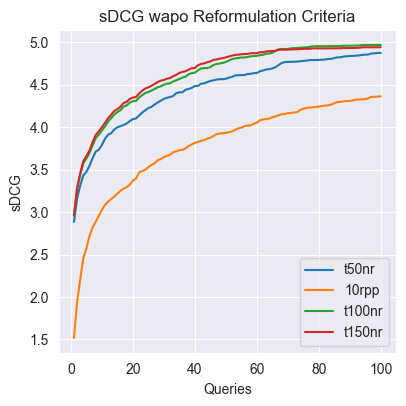

In [67]:
#sDCG_lev('nyt',users, c_users, plot2=True, plot3=True)
#sDCG_lev('nyt',strats)
#sDCG_lev('wapo',rankings,plot2=True,plot3=True)
sDCG_lev('wapo',crits,c_crits)

In [40]:
# Auswertung aller logfiles einer Simulation (die hier übergeben werden); OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def sDCG_all(sim, logfiles):
    full_eval = {}
    sdcg_eval = {}
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")

    for f in logfiles:
        log_path = f
            
        query_logs = {}        
        query = ''
        results = []
                        
        with open(log_path, errors='ignore') as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') # Wird hinzugefügt, damit die Position der betrachteten Dokumente stimmt, aber ohne Dokumentenname, weil es nicht betrachtet wurde und damit auch kein Wissen aus dem Dokument gewonnen wurde

                elif logs[1] == 'DOC': # Auch nicht relevante Ergebnisse in results einfügen
                #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':    
                    results.pop() # Vor Doc kommt immer Snippet des selben Dokuments und dafür wurde dann schon only_snippet hinzugefügt. Wenn das Dokument danach betrachtet wurde, muss das gelöscht werden              
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))   

                elif logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                    query_logs[query] = results

        sdcg = {}
        _sdcg = 0.0

        topic = log_path.split('-')[2]

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
            sdcg[q+1] = _sdcg
        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
        last_sdcg = sdcg[len(sdcg)]
        for i in range(len(sdcg)+1,querynumber_sDCG+1):
            sdcg[i] = last_sdcg
            
        sdcg_eval[f] = sdcg
    full_eval[0] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()

    print('sDCG evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sDCG "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(sdcg_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sDCG, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/sdcg.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

sDCG evaluation of all wapo files
number of sessions: 450
minimum / maximum / average queries per session: [38, 100, 90]


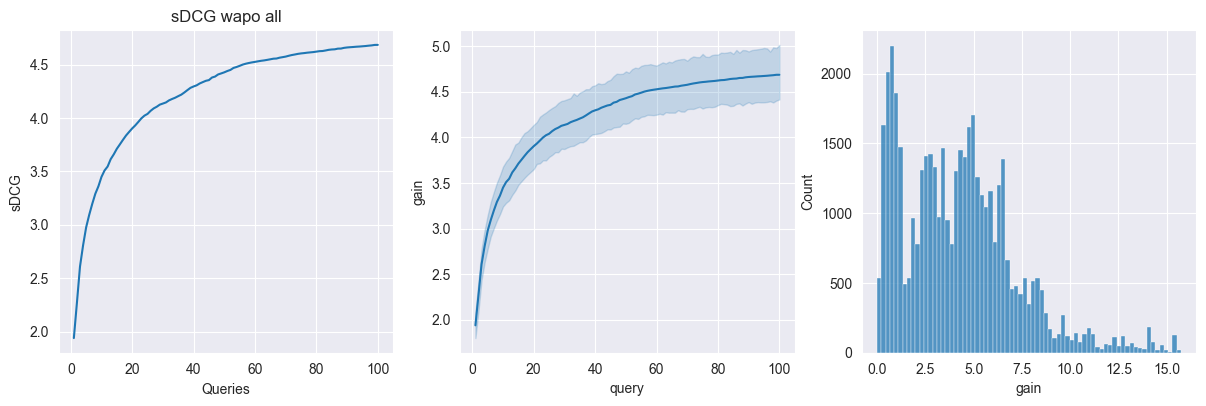

In [41]:
selected_files = filter_logfiles(log_files, sims = 'wapo', rankings = ['monoT5','monoT5cut200']) # filter_logfiles gibt alle Logdateien zur angegebenen Simulation/Simulationen zurück mit den angegebenen Einschränkungen (keine Angabe = alle Ausprägungen)
#selected_files = sim_files('wapo', log_files) # sim_files gibt alle Logdateien zur angegebenen Simulation zurück
sDCG_all('wapo', selected_files)
#sDCG_all('nyt',sim_files('nyt',log_files))

## Effort vs. Effect ##

In [82]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)
    
    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    _gain = 0
                    gain = {}  

                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                if logs[1] == 'DOC':
                                #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    
    print('Effect vs. Effort evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("Effort vs Effect "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/effort_effect.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [81]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)
    
    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    _gain = 0
                    gain = {}  

                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                if logs[1] == 'DOC':
                                #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    return level_eval

Effect vs. Effort evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


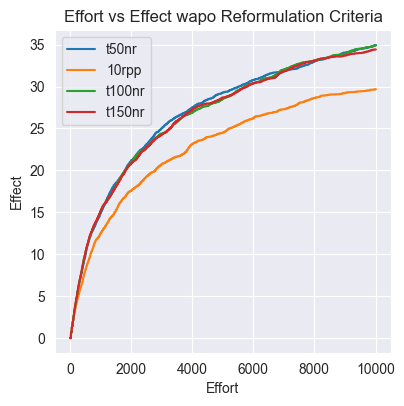

In [18]:
#effeff_lev('wapo',strats, plot2=True)
effeff_lev('wapo', crits, c_crits)

In [43]:
# Auswertung aller logfiles einer Simulation; OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def effeff_all(sim, logfiles):
    full_eval = {}
    gain_all = {}
    eval_all = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    for f in logfiles:
        log_path = f
        topic = log_path.split('-')[2]
            
        _gain = 0
        gain = {}
                        
        with open(log_path, errors='ignore') as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'DOC':
                    #if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')  
                        if qrels.get((topic,result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain

        gain_all[f] = gain
    full_eval[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
    eval_all[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()

    print('Effort vs Effect evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("Effort vs Effect "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', legend=False, ax=ax1)
    #leave out for performance reasons

    #ax2 = fig.add_subplot(1,3,2)
    #eva_df = pd.DataFrame.from_dict(eval_all[0], orient="index").stack().to_frame()
    #eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','cost'])
    #eva_df = eva_df.rename(columns={0:'gain'})
    #eva_df = eva_df[eva_df.apply(lambda row: row['cost'] <= 10000, axis=1)]
    #sns.lineplot(data = eva_df, x='cost',y='gain', ax=ax2)
    #ax3 = fig.add_subplot(1,3,3)
    #sns.histplot(eva_df['gain'], ax= ax3)

    #plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/effort_effect.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

Effort vs Effect evaluation of all nyt files
number of sessions: 1350
minimum / maximum / average queries per session: [28, 236, 100]


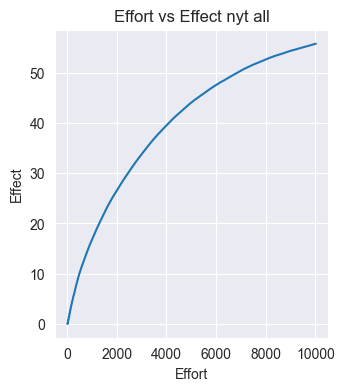

In [44]:
effeff_all('nyt',sim_files('nyt',log_files))

## sRBP ##

In [72]:
# Aldo Lipani sRBP (https://github.com/aldolipani/sRBP/blob/master/main.ipynb)

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def session_based_measure(d, sessions):
    res = 0.0
    for session in sessions:
        n=0 # rank
        m=0 # reformulation
        for event in session:
            if event.startswith('q'):
                m=0
                n=0
            elif event == 'r':
                n=0
                m+=1
            elif event.endswith('-1'):
                res+= d(m, n)
                n+=1
            elif event != 'f':
                n+=1

        res/=len(sessions)

        return res
    
# sRBP for all sessions
def srbp(b, p, sessions):
    return (1-p)*session_based_measure(lambda m, n : d_srbp(b, p, m, n), sessions)
# 1 - p: normalization factor

In [73]:
# b_p_srbp(log_files): determine best b and p for sRBP based on the log data (using all log-files for overall value or a specific part for example for one simulation)
# the code is from Aldo Lipani (https://github.com/aldolipani/sRBP/blob/master/main.ipynb) and only slightly modified to fit the log-file format
# returns best_b, best_p
def b_p_srbp(log_files):

    max_reformulation = 0
    max_rank = 0

    # determine max reformulation and max rank
    for log_file in log_files:
        m = -1 # -1 statt 0, weil bei der ersten Query (also Erstformulierung, nicht NEUformulierung) schon der Wert erhöht wird; im Original (von Lipani) lässt sich die erste Query einer Session von den anderen unterscheiden
        n = 0
        with open(log_file, errors='ignore') as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                    if m > max_reformulation:
                        max_reformulation = m
                if parts[1] == 'SNIPPET':
                    n += 1
                    if n > max_rank:
                        max_rank = n

            
    count = [[0] * max_rank for i in range(max_reformulation+1)]
    for log_file in log_files:
        m = -1 # s.o.
        n = 0
        with open(log_file, errors='ignore') as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                if parts[1] == 'SNIPPET':
                    count[m][n] += 1
                    n += 1
            
    df = pd.DataFrame(count)
    df = df/df.values.sum()
    gt = df.values
    df.transpose()

    M = gt.shape[0]
    N = gt.shape[1]

    min_err = sys.float_info.max
    res = 100
    best_p = -1
    best_b = -1
    grid = {}

    def tse_srbp(b, p):
        norm = 0.0
        for i in range(M*N):
            norm += d_srbp(b, p, i//N, i%N)
        err = 0.0
        for i in range(M*N):
            err += (gt[i//N, i%N]-d_srbp(b, p, i//N, i%N)/norm)**2
        return err

    t = tqdm(np.linspace(0, 1, res+1), desc = "TSE: {:.4f}".format(min_err))
    for p_i, p in enumerate(t):

        grid[p_i] = []
        for b in np.linspace(0, 1, res+1):
            
            err = tse_srbp(b, p)
            
            grid[p_i].append(err)

            if err < min_err:
                min_err = err
                best_p = p
                best_b = b
                t.set_description("TSE: {:.4f}".format(min_err))

    grid = pd.DataFrame.from_dict(grid)

    srbp_best_b = best_b
    srbp_best_p = best_p

    print("b =", best_b, ", p =", best_p, ", TSE = {:.4f}".format(min_err))
    return best_b, best_p

In [74]:
# sRBP parameters
p_srbp = 0.99 # persistence parameter (Wahrscheinlichkeit, die Suche fortzusetzen)
b_srbp = 0.9 # balance parameter (Balance zwischen "das nächste Element betrachten" und "die Query neu formulieren")
#b_srbp, p_srbp = b_p_srbp(log_files) # b und p basierend auf den logfiles

# ACHTUNG! Bei den aktuellen Daten wurde 1 als Wert für best_p berechnet. Da das Ergebnis allerdings mit (1-p) multipliziert wird, ist das Ergebnis dann immer 0 und damit nicht aussagekräftig

In [75]:
# sRBP value for one session (using discount function from Lipani)
def s_rbp(b, p, log_path, topic, qrels):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path, errors='ignore') as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count
                n += 1

            elif logs[1] == 'DOC': # add d_srbp value for clicked document to the result          
            #elif logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT': 
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res += d_srbp(b, p, m, n)
                        #print('dsrbp: ' + str(d_srbp(b,p,m,n)))
                        #print('res: ' + str(res))

    return (1-p)*res, query_rbp # return sRBP for whole session, list of sRBP values after each query

In [76]:
def sRBP_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1] 

                    # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                    last_srbp = srbp[len(srbp)-1]
                    for i in range(len(srbp),querynumber_sRBP):
                        srbp[i] = last_srbp    

                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber_sRBP].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    print('sRBP Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sRBP "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/srbp.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [77]:
def sRBP_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1] 

                    # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                    last_srbp = srbp[len(srbp)-1]
                    for i in range(len(srbp),querynumber_sRBP):
                        srbp[i] = last_srbp    

                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber_sRBP].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    return level_eval

sRBP Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


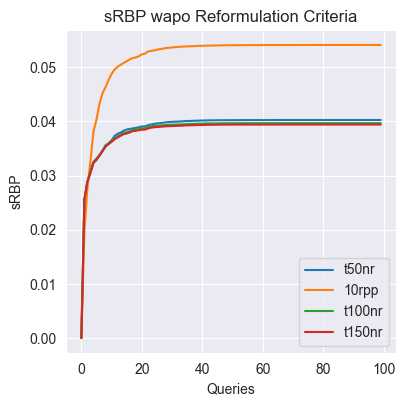

In [27]:
#sRBP_lev('wapo', rankings, plot2=True,plot3=True)

sRBP_lev('wapo', crits, c_crits)

In [118]:
# sRBP Wert für alle übergebenen logfiles (ohne auf Usertyp o.ä. einzugehen)
def sRBP_all(sim, logfiles):

    full_eval = {}
    srbp_eval = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    for f in logfiles:
        log_path = f
        
        topic = log_path.split('-')[2]

        srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1]
        
        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
        last_srbp = srbp[len(srbp)-1]
        for i in range(len(srbp),querynumber_sRBP):
            srbp[i] = last_srbp 

        srbp_eval[f] = srbp
    
    full_eval[0] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()

    print('sRBP evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sRBP "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(srbp_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sRBP, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/srbp.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## Gesamtevaluation ##

In [34]:
# Gesamte Evaluation: Es werden alle Graphen gezeigt für jedes Evaluationslevel und jede Simulation (auf Levelebene und allgemein) 
def full_evaluation():
    for sim in sims:
        print(sim)
        sDCG_all(sim, sim_files(sim,log_files))
        effeff_all(sim, sim_files(sim,log_files))
        sRBP_all(sim, sim_files(sim,log_files))
        for level in levels:
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)

# ANMERKUNG: Wenn man (sDCG/effeff/sRBP)_all so verwendet wie hier und einfach alle Logdateien übergibt, kann das Ergebnis natürlich sehr schwierig zu interpretieren 
# sein. Man kann aber vorher die Logdateien herausfiltern (z.B. mit filter_logfiles), die man übergeben möchte, und sie dann gezielt auswerten.



In [122]:
# Gesamte Evaluation für eine ausgewählte Simulation
def sim_evaluation(sim):
    print(sim)
    for level in levels:
            #sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
    sDCG_all(sim, sim_files(sim,log_files))
    effeff_all(sim, sim_files(sim,log_files))
    sRBP_all(sim, sim_files(sim,log_files))

## Snippets per Query ##

In [133]:
# number of snippets seen per query with different stopping criteria
def snippets_query(sim, level, fixed_values = {}):
        
    evaluation_level = levelname(level,levels,levelnames)

    level_eval = {}
    snippets_eval = {}


    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in fixed_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            snippets_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}           
                    query = 0
                    results = 0
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if query > 0:
                                    query_logs[query] = results
                                results = 0
                                query += 1
                                
                            if logs[1] == 'SNIPPET':
                                results += 1   

                            if logs[0] == 'INFO':
                                query_logs[query] = results

                        snippets_eval_combi[c] = query_logs
                        c += 1
            snippets_eval[topic] = pd.DataFrame.from_dict(snippets_eval_combi)[:querynumber].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(snippets_eval)[:querynumber_sDCG].T.mean().to_dict()

    print('Snippets per query: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    fig=plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title("Snippets per query "+sim+ " " + evaluation_level)
    pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='Snippets', ax = ax1)
    #ax1.set_xlim([0, querynumber_sDCG-1])
    #ax1.set_ylim(bottom = 0)
    plt.show()

## Comparing two plots ##

In [68]:
def compare_two_plots(p1, p2):
    for i, key in enumerate(p1.keys()):
        plt.plot(np.array(list((p1[key].values()))),label=key, color=colors[i])
        plt.plot(np.array(list((p2[key].values()))),linestyle='--', color=colors[i])
    plt.legend()
    plt.show()

## Beispiele ##

sDCG Evaluation: wapo Users
Combinations used in this evaluation: [['bm25', 'GPT+', 'navigational', '10rpp'], ['bm25', 'GPT+', 'almostrandom', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'informational', '10rpp']]


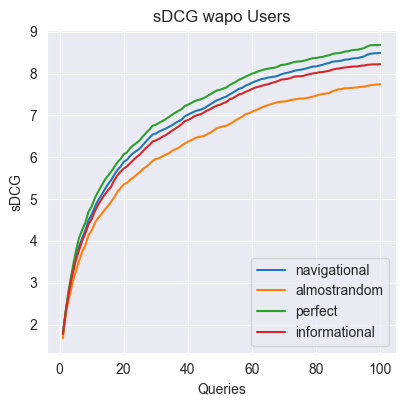

Effect vs. Effort evaluation: nyt Query Strategies
Combinations used in this evaluation: [['bm25', 'D2Q+', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'GPT', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp'], ['bm25', 'D2Q', 'perfect', '10rpp']]


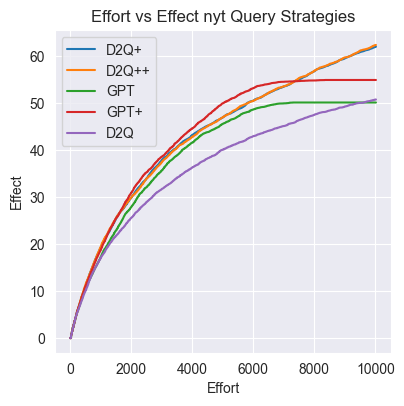

sRBP Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


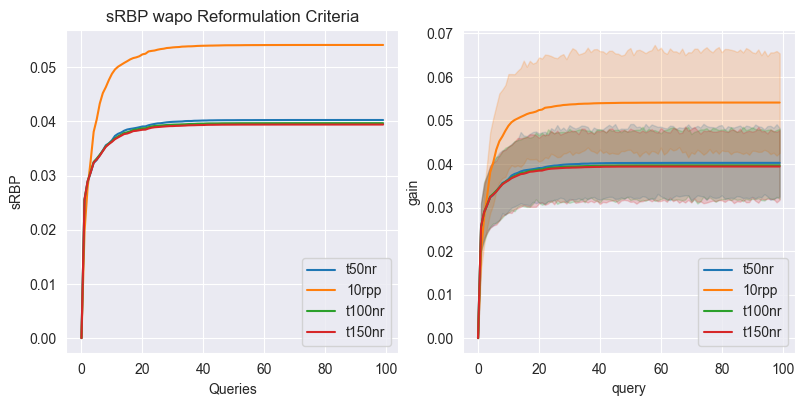

In [125]:
# Beispiele 
sDCG_lev('wapo', users, c_users, plot1=True, plot2=False, plot3=False)
effeff_lev('nyt', strats, c_strats, plot1=True, plot2=False, plot3=False)
sRBP_lev('wapo', crits, c_crits, plot1=True, plot2=True, plot3=False)
#effeff_all('wapo', sim_files('wapo', log_files))
#full_evaluation()
#sim_evaluation('wapo')

Snippets per query: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


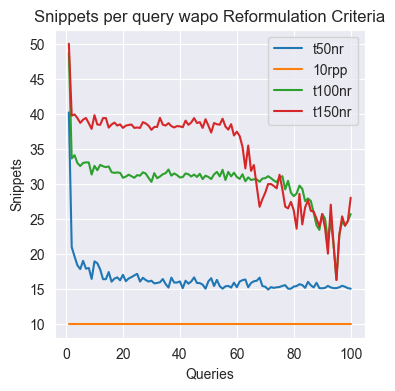

In [138]:
snippets_query('wapo',crits,c_crits)

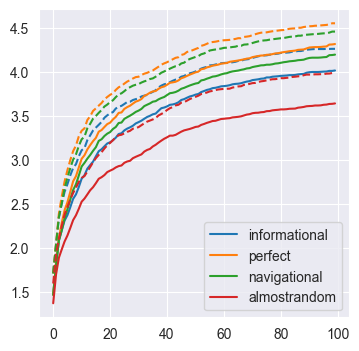

In [89]:
p1 = sDCG_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
p2 = sDCG_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

#p1 = sDCG_lev_for_comparison('wapo',crits,{'query_type':['GPT'], 'crit':['10rpp','t50nr'], 'user': ['informational'], 'ranking':['bm25']},plot1=False)
#p2 = sDCG_lev_for_comparison('wapo',crits,{'query_type':['GPT'], 'crit':['10rpp','t50nr'], 'user': ['informational'], 'ranking':['monoT5']},plot1=False)

#p1 = sRBP_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
#p2 = sRBP_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

#p1 = effeff_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
#p2 = effeff_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

compare_two_plots(p1,p2)

# Hier sind Beispiele zu allen Maßen, teilweise mit users bzw. crits. Wenn zwei Ranking-Methoden verglichen werden sollen, einfach zweimal die gleiche Zeile angeben nur
# mit anderer Methode. Theoretisch können auch andere Vergleiche hiermit gemacht werden. Es wird immer das, was als zweites angegeben wird, gestrichelt dargestellt. 